## Data Analysis

Data is given in JSON format.

**Given data fields:** Headline, Datecreated, Airdate, Searchabletext, Abstract, Fulltext, Programname, Sourcename, Mediatype, Commentator, Articletype, Sourcesystem, State, Country, Entityname, Companyname, Deliverysetname, Briefname, Prospectkeyword.

__Some of these features are redundant and can be removed.__

__Steps:__
1. Read JSON data
2. Check data types of each field. For example, Searchabletext is in XML format that contains other fields
3. Check for missing values and duplicates
4. Data cleaning and preprocessing
5. Feature engineering
6. Nested clustering
7. Topic modeling


__My Approach:__
- Principal component analysis followed by t-SNE for dimensionality reduction and data visualization.
- K-Means clustering using categorical features. Elbow method is used to find optimal number of clusters.
- Now in each cluster, using abstract feature to create clusters within that cluster using tf-idf and k-means algorithm.
- Latent Dirichlet allocation for topic modeling
- Proposing names for each of these clusters 





In [1]:
import pandas as pd
import json
import re
import nltk
import string
import xmltodict
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter

import re
import category_encoders as ce
from scipy import stats
import pylab as pl
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

__1. Reading Data__

In [2]:
# load JSON data
with open('NLP-test-modified.json','r') as f:
    data = json.loads(f.read())   

In [3]:
# Normalizing data
df = pd.json_normalize(data['hits']['hit'])
df.columns = df.columns.str.replace('_source.', '') #_source is applied for 
                                                #fields after flattening so removing that for better readability

# Separating continuous and categorical features
categorical_list = ['programname','sourcename','mediatype','commentator','articletype',
                    'sourcesystem','country','entityname','companyname','deliverysetname','briefname']
continuous_list = ['headline','searchabletext','abstract','fulltext','prospectkeyword']

# Assign only above needed features  and remove all other unnecessary features such as metaitemid index,type etc.
df = df[continuous_list + categorical_list]
df.head()

,headline,searchabletext,abstract,fulltext,prospectkeyword,programname,sourcename,mediatype,commentator,articletype,sourcesystem,country,entityname,companyname,deliverysetname,briefname
0,Taiwan's budget carrier V Air to cease operations,"<root><item><id xml:lang=""en-US"">649151843</id...",Taiwanese regional budget carrierV Air will go...,\r\n Taiwanese regional budget carrierV Air...,"Airways,announced,business,capital,industry,la...",General News,Asian Aviation,Magazine,None,News Item,Press,Australia,Asian Aviation,Etihad Airways,My133 3,Competitors Press
1,China high on AirAsia wishlist,"<root><item><id xml:lang=""en-US"">649157337</id...",AAV European contributor Ian Goold explains wh...,\r\n AAV European contributor Ian Goold exp...,"Femandes,Fernandes,Tony",General News,Asian Aviation,Magazine,Lan Goold,News Item,Press,Australia,Asian Aviation,Qantas Airways Ltd,My133 3,Jetstar - Press
2,Auto-braking decreases rear-end crash rates,"<root><item><id xml:lang=""en-US"">636904890</id...",Research in the US has found that automatic br...,\r\n Research in the US has found that auto...,"automated,automatic,braking,City Safety,Insura...",General News,Horizons,Magazine,None,News Item,Press,Australia,None,Volvo Car Australia Pty Ltd,My133 3,Volvo - Press
3,VIRGIN AUSTRALIA WIFI,"<root><item><id xml:lang=""en-US"">649158227</id...",Virgin Australia has confirmed that it will la...,\r\n Virgin Australia has confirmed that it...,"Airbus,airline,announced,Australia,Boeing,flee...",General News,Asian Aviation,Magazine,None,News Item,Press,Australia,Asian Aviation,Etihad Airways,My133 3,Competitors Press
4,EDITOR'S LETTER,"<root><item><id xml:lang=""en-US"">649257078</id...",It may just be the people I follow on Instagra...,\r\n It may just be the people I follow on ...,"Airways,Etihad,route",Wish,The Australian,Newspaper,David Meagher,News Item,Press,Australia,The Australian,Etihad Airways,My133 3,Etihad Airways Press


**Data analysis**

Missing data: From the below overview of the data, it can be seen that full text is missing for almost half of the data. Entity name is also missing for almost 38% of data and article type is missing for 4.5% of data and prospect keyword is missing for only 2 records.

Searchable text is XML that contains all other features. So it needs to be processed:
- To find missing data for full text and entity name
- To see if it contains any other useful information

In [4]:
# Overview of the features
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   headline         300 non-null    object
 1   searchabletext   300 non-null    object
 2   abstract         300 non-null    object
 3   fulltext         158 non-null    object
 4   prospectkeyword  298 non-null    object
 5   programname      300 non-null    object
 6   sourcename       300 non-null    object
 7   mediatype        300 non-null    object
 8   commentator      300 non-null    object
 9   articletype      284 non-null    object
 10  sourcesystem     300 non-null    object
 11  country          300 non-null    object
 12  entityname       186 non-null    object
 13  companyname      300 non-null    object
 14  deliverysetname  300 non-null    object
 15  briefname        300 non-null    object
dtypes: object(16)
memory usage: 37.6+ KB


In [5]:
for item in categorical_list:
    print("==============="+item+"===============")
    print(df[item].value_counts())
    print()

===============programname===============
Other                                   138
General News                             93
Business News                            29
Letters                                   5
Aviation                                  4
Travel                                    4
Escape                                    4
International News                        2
Opinion                                   2
Business Day                              2
www.wazzuppilipinas.com                   1
dtinews.vn/en/news/018/business.html      1
www.talkvietnam.org/                      1
Business Review                           1
Arts & Entertainment                      1
The Business                              1
Inquirer                                  1
Traveller                                 1
Supplements                               1
Smart Investor                            1
IT Today                                  1
Property                          

In [6]:
# Removing duplicates
df.drop_duplicates(subset="headline",keep='last', inplace=True)

In [7]:
df.shape

(271, 16)

In [8]:
def parse_xml(xml,missing_val):
    '''
    Parse XML data
    '''
    data = xmltodict.parse(xml)
    try:
        return data['root']['item'][missing_val]['#text']
    except:
        return None

# Extracting missing full text and entity names
df['newfulltext'] = df['searchabletext'].apply(lambda x:parse_xml(x,'full'))
df['newentityname'] = df['searchabletext'].apply(lambda x:parse_xml(x,'src'))

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 299
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   headline         271 non-null    object
 1   searchabletext   271 non-null    object
 2   abstract         271 non-null    object
 3   fulltext         141 non-null    object
 4   prospectkeyword  269 non-null    object
 5   programname      271 non-null    object
 6   sourcename       271 non-null    object
 7   mediatype        271 non-null    object
 8   commentator      271 non-null    object
 9   articletype      255 non-null    object
 10  sourcesystem     271 non-null    object
 11  country          271 non-null    object
 12  entityname       166 non-null    object
 13  companyname      271 non-null    object
 14  deliverysetname  271 non-null    object
 15  briefname        271 non-null    object
 16  newfulltext      141 non-null    object
 17  newentityname    271 non-null    ob

__Feature Engineering:__

- Missing full text and entity names are missing from searchable text as well so they need to be dropped
- Searachable text is XML data that contains information that is already given and it does not offer any new information so it can be removed as well
- Deliverysetname has 2 values where only 2 data row belongs to  'Volvo commercial vehicles' and rest belongs to 'My133 3' so it can removed 
- (News item + letter) from article type can be mapped to 'Press' in source system, and 'Internet' can be mapped to 'Internet' in source system
- Also there is a relation between source system and brief name. Breif name contains the name of the exact source system
- Also there is a relation between media type and source system. 'Newspaper + magazine'from media type can be mapped to 'Press' in source system and 'Internet + Social + blog' can be mapped to 'Internet' in source system 

In [10]:
# Removing redundant and missing features
df.drop(['fulltext','commentator','entityname','searchabletext',
         'deliverysetname','articletype','newfulltext','newentityname','mediatype'], axis = 1,inplace=True)  

In [11]:
def clean_text(text):
    """
    Function to keep only letters and remove stopwords
    Returns a string of the cleaned text
    """
    letters_only = re.sub('[^a-zA-Z]', ' ', text)
    words = letters_only.lower().split()
    stopwords_eng = set(stopwords.words("english"))
    lemmatized_words = [lemmatizer.lemmatize(x) for x in words if not x in stopwords_eng]
    useful_words = [word for word in lemmatized_words if not (len(word)<=3)]
  
    
    # Combine words into a paragraph again
    useful_words_string = ' '.join(useful_words)
    return(useful_words_string)



In [12]:
df['abstract'] = df['abstract'].apply(clean_text)
df['headline'] = df['headline'].apply(clean_text)

In [13]:
df.head(5)

,headline,abstract,prospectkeyword,programname,sourcename,sourcesystem,country,companyname,briefname
0,taiwan budget carrier cease operation,taiwanese regional budget carrierv business oc...,"Airways,announced,business,capital,industry,la...",General News,Asian Aviation,Press,Australia,Etihad Airways,Competitors Press
1,china high airasia wishlist,european contributor goold explains paying din...,"Femandes,Fernandes,Tony",General News,Asian Aviation,Press,Australia,Qantas Airways Ltd,Jetstar - Press
2,auto braking decrease rear crash rate,research found automatic braking system reduce...,"automated,automatic,braking,City Safety,Insura...",General News,Horizons,Press,Australia,Volvo Car Australia Pty Ltd,Volvo - Press
3,virgin australia wifi,virgin australia confirmed launch flight wifi ...,"Airbus,airline,announced,Australia,Boeing,flee...",General News,Asian Aviation,Press,Australia,Etihad Airways,Competitors Press
4,editor letter,people follow instagram seems like everyone go...,"Airways,Etihad,route",Wish,The Australian,Press,Australia,Etihad Airways,Etihad Airways Press


In [14]:
# Encoding categorical features
categorical_list = ['programname','sourcename','sourcesystem','country','companyname','briefname']

be = ce.BinaryEncoder(cols = categorical_list,drop_invariant = True).fit(df[categorical_list]) 

df_cat = be.transform(df[categorical_list])
df_cat.head(5)

,programname_1,programname_2,programname_3,programname_4,programname_5,sourcename_1,sourcename_2,sourcename_3,sourcename_4,sourcename_5,...,country_2,companyname_1,companyname_2,companyname_3,briefname_1,briefname_2,briefname_3,briefname_4,briefname_5,briefname_6
0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,1,1
3,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


__PCA & t-SNE for dimensionality reduction in a pipeline__

In [15]:
import time
pca_tsne = Pipeline([("pca", PCA(n_components = 2)),
                    ("tsne", TSNE(n_components = 2,
                                  perplexity = 40, 
                                  learning_rate = 350, 
                                  n_iter = 300,
                                  verbose = 1))])
t0 = time.time()
df_pca_tsne_reduced = pca_tsne.fit_transform(df_cat)
t1 = time.time()

print("pca+tsne took:{:.1f}s ".format(t1-t0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 271 samples in 0.000s...
[t-SNE] Computed neighbors for 271 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 271 / 271
[t-SNE] Mean sigma: 0.285398
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.409378
[t-SNE] KL divergence after 300 iterations: 0.134625
pca+tsne took:0.4s 


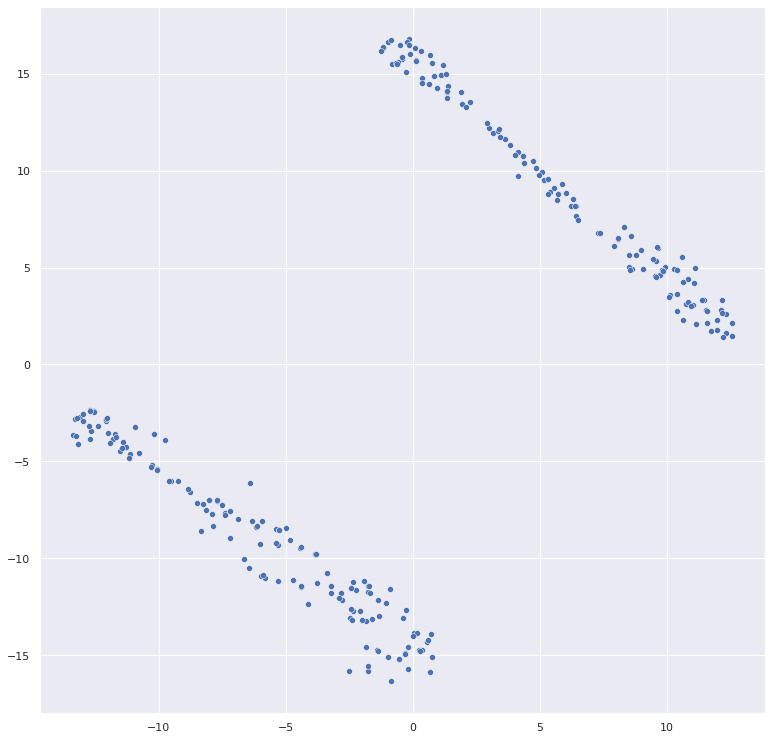

In [16]:
import seaborn as sns
sns.set(rc= {'figure.figsize': (13,13)})
sns.scatterplot(df_pca_tsne_reduced[:,0], df_pca_tsne_reduced[:,1])
plt.show()

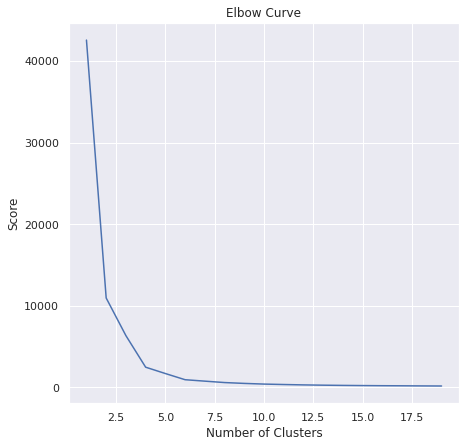

Plotting the Elbow curve took:1.3s 


In [17]:
data_std = stats.zscore(df_pca_tsne_reduced)
data_std = np.array(data_std)

sns.set(rc = {'figure.figsize': (7,7)})
number_of_clusters = range(1,20)

t0 = time.time()
kmeans = [KMeans(n_clusters=i,max_iter=1000,random_state=55,n_jobs=-1) for i in number_of_clusters]
score = [-1*kmeans[i].fit(df_pca_tsne_reduced).score(df_pca_tsne_reduced) for i in range(len(kmeans))]
t1 = time.time()

pl.plot((number_of_clusters),score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

print("Plotting the Elbow curve took:{:.1f}s ".format(t1-t0))

__Clustering based on categorical data__

From the elbow curve, we can see that ideal number of cluseters is 2. Btw this can be also confirmed from PCA & t-SNE

So only based on categorical data, we will do clustering

In [18]:
k_means = KMeans(n_clusters=2, max_iter=1500, random_state=33,verbose=1, n_jobs=-1)
#fitting on your model
-1*k_means.fit(df_pca_tsne_reduced).score(df_pca_tsne_reduced)
y_pred= k_means.labels_

# Assigning cluster labels to each data point
df['klabels'] = k_means.labels_

Initialization complete
Iteration 0, inertia 20081.326171875
Iteration 1, inertia 10948.7548828125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 15638.375
Iteration 1, inertia 10948.7548828125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 15952.599609375
Iteration 1, inertia 10948.7548828125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 29856.798828125
Iteration 1, inertia 10948.7548828125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 18512.720703125
Iteration 1, inertia 10948.7548828125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 29368.984375
Iteration 1, inertia 10948.7548828125
Converged at iteration 1: strict convergence.
Initialization complete
Iteration 0, inertia 30503.4921875
Iteration 1, inertia 10948.7548828125
Converged at iteration 1: strict convergen

In [19]:
# Analyzing clustets generated on categorical data
size_of_each_cluster= df.groupby('klabels').size().reset_index()
size_of_each_cluster.columns = ['klabels','number_of_points']
size_of_each_cluster['percentage'] = (size_of_each_cluster['number_of_points']/np.sum(size_of_each_cluster['number_of_points']))*100

print(size_of_each_cluster)

   klabels  number_of_points  percentage
0        0               141    52.02952
1        1               130    47.97048


__Nested Clustering:__

We get two clusters after performing clustering based on categorical data 
Now within this each cluster, we will perform clustering based on the abstract texts

In [20]:
df0 = df[df['klabels'] == 0] #First cluster based on categorical data
df1 = df[df['klabels'] == 1] #Second cluster based on categorical data

df0.reset_index(inplace=True)
df1.reset_index(inplace=True)

In [21]:
def find_cluster_in_partition(dftemp,index_for_cluster):
    
    '''
        Performs nested clustering
    '''
    
    # Converting abstract dataframe into list
    abstracts = dftemp['abstract'].tolist()
    
    # Generating a pattern based tokenizer
    token_pattern = '(?u)\\b[a-zA-Z][a-zA-Z]+\\b'
    token_expression = re.compile(token_pattern)
    abstract_tokenizer = lambda abstract: token_expression.findall(abstract)
    
    # Building a dictionary for tokens in abstracts
    words = [word for abstract in abstracts for word in abstract_tokenizer(abstract)]
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    stems = (stemmer.stem(word) for word in words)

    word_for_stem = pd.DataFrame({ 'stem': stems, 'word': words }).set_index('stem').sort_index()
    word_for_stem = word_for_stem.loc[~word_for_stem.index.duplicated(keep='first')]
 
    # TF-IDF Vectorizer for abstract tokens
    vectorizer = TfidfVectorizer(tokenizer=abstract_tokenizer)
    abstract_vectors = vectorizer.fit_transform(abstracts)

    # Clustering using KMeans
    n_clusters = 4
    clusterer = KMeans(n_clusters, random_state=1)
    cluster_indices = pd.Series(
        clusterer.fit_predict(abstract_vectors), 
        name='ClusterIndex'
    )
    clustered_data = dftemp.join(cluster_indices)
   
    # Converting clusters ranking to join a previous sequence
    for i in range(n_clusters):
        clustered_data.loc[(clustered_data['ClusterIndex'] == float(i)), 'ClusterIndex'] = index_for_cluster + i
    return clustered_data

In [22]:
# Finding clusters within Cluster 0 of categorical data
cluster_cluster0 = find_cluster_in_partition(df0,0)

# Finding clusters within Cluster 1 of categorical data
cluster_cluster1 = find_cluster_in_partition(df1,4)

# Combining nested clusters to generate final clustering
clustered_data_abstract = pd.concat([cluster_cluster0,cluster_cluster1])
clustered_data_abstract.reset_index(inplace=True)

__Analyzing generated clusters__

In [23]:
print(clustered_data_abstract['ClusterIndex'].value_counts())

0    66
4    49
6    37
1    27
3    26
7    24
2    22
5    20
Name: ClusterIndex, dtype: int64


In [24]:
def get_pos_tag(tag):
    """
    WordNet to find Part-of-Speech tags
    """
    
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

In [25]:
def tokenize(text):
    '''
    Tokenize words using NLTK
    '''
    doc_tokens = nltk.word_tokenize(text)
    return doc_tokens

df_clean = clustered_data_abstract['abstract'].apply(tokenize)
df_clean.head()

0    [taiwanese, regional, budget, carrierv, busine...
1    [european, contributor, goold, explains, payin...
2    [research, found, automatic, braking, system, ...
3    [virgin, australia, confirmed, launch, flight,...
4    [people, follow, instagram, seems, like, every...
Name: abstract, dtype: object

In [26]:
# Identfiytopic results using Nouns and Verbs
# Nouns denote the entities and verbs denote the actions
def get_nouns_verbs(series):
    '''
    Identifying all nouns and verbs
    '''

    pos_tags = nltk.pos_tag(series)
    all_noun_verbs = [word for (word, tag) in pos_tags if (tag.startswith("N") or tag.startswith("V"))] 
    return all_noun_verbs

df_nouns_verbs = df_clean.apply(get_nouns_verbs)

In [27]:
noun_verb_list = list(df_nouns_verbs)
phrases = gensim.models.Phrases(noun_verb_list, min_count=10, threshold=20)

#Bi-gram model
bigram_model = gensim.models.phrases.Phraser(phrases)

In [28]:
def make_bigrams(texts):
    '''
    Generating bi-grams
    '''
    return [bigram_model[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(noun_verb_list)


In [29]:
#Listing most frequent bigrams :
bigram_counter1= Counter()
for key in phrases.vocab.keys():
    if key not in stopwords.words('english'):
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(20):
    print(key,"---->", counts)


alan_joyce ----> 9
credit_card ----> 8
year_june ----> 8
executive_alan ----> 8
commonwealth_bank ----> 7
cash_bonus ----> 7
record_profit ----> 7
cost_carrier ----> 6
soared_year ----> 6
qantas_alan ----> 6
fixed_fixed ----> 6
business_traveller ----> 5
reserve_bank ----> 5
home_loan ----> 5
security_investment ----> 5
investment_commission ----> 5
cent_year ----> 5
bank_bank ----> 5
advertising_marketing ----> 5
virgin_australia ----> 4


In [30]:
# Generating a dictionary of bi-grams
dictionary = Dictionary(data_words_bigrams)

# Filter out words that occur less than 20 documents, or more than 70% of the documents.
dictionary.filter_extremes(no_below = 0.2, no_above = 0.7)
corpus = [dictionary.doc2bow(noun_verb) for noun_verb in noun_verb_list]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2274
Number of documents: 271


In [31]:
from gensim.models.ldamulticore import LdaMulticore

t0= time.time()
passes= 150
np.random.seed(1) # setting up random seed to get the same results

lda = LdaMulticore(corpus, 
                    id2word=dictionary, 
                    num_topics=5,  
                    chunksize= 4000, 
                    batch= True,
                    minimum_probability=0.001,
                    iterations=350,
                    passes=passes)                    

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")

time for 150  passes:  21.70066785812378  seconds


In [32]:
# Show topics from LDA
lda.show_topics(num_words=30, formatted=False)

[(0,
  [('airline', 0.015423909),
   ('year', 0.014664886),
   ('flight', 0.013911481),
   ('bank', 0.013678625),
   ('rate', 0.008231897),
   ('service', 0.008074707),
   ('qantas', 0.007671545),
   ('customer', 0.00670699),
   ('cent', 0.006481637),
   ('sydney', 0.0062017106),
   ('week', 0.0050420756),
   ('data', 0.0046742386),
   ('fare', 0.004169959),
   ('fixed', 0.0041676858),
   ('traveller', 0.0040763062),
   ('show', 0.0039643967),
   ('package', 0.0036672645),
   ('nation', 0.0036601177),
   ('australia', 0.00365973),
   ('figure', 0.0036574118),
   ('joyce', 0.003607626),
   ('home', 0.003604658),
   ('news', 0.0031524387),
   ('commonwealth', 0.0031515756),
   ('marketing', 0.0031514638),
   ('award', 0.0031508533),
   ('advertising', 0.0031506086),
   ('pilot', 0.0030969249),
   ('said', 0.003093591),
   ('june', 0.0030493638)]),
 (1,
  [('airline', 0.016842524),
   ('year', 0.015568713),
   ('business', 0.008667091),
   ('government', 0.0074358997),
   ('joyce', 0.0073

In [33]:
lda_corpus = lda[corpus]

In [34]:
# Obtaining the main topic for each review:

all_topics = lda.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()

major_topic= [np.argmax(arr) for arr in all_topics_numpy]
clustered_data_abstract['major_lda_topic']= major_topic

In [ ]:
# Identifying major topics for each cluster
clustered_data_abstract.groupby(['ClusterIndex'])['major_lda_topic'].value_counts(ascending=False, normalize=True)

In [39]:
# Identifying data that belongs to cluster 5
cluster_5 = clustered_data_abstract[clustered_data_abstract['ClusterIndex'] == 5]

In [40]:
# Analyzing data for example cluster 5
print(cluster_5['headline'])

154                                 oneworld name gurney
157          treehotel lulea sweden review world coolest
160                                 volvo song open road
180               qantas share surge windfall alan joyce
183              audi factory backed team formula series
187     free practice flash girolami leaf late wtcc time
200                  polestar continue working hard wtcc
204     volvo autoliv form self driving software company
232                        vistara offer discounted fare
233          volvo autoliv form driverless joint venture
236                     aussie dollar soar shocking data
239                     self drive test planned tauranga
252    wrong plane melbourne instead malaysia pilot e...
254    anyone interested fast volvo polestar pumped s...
258                                 rally misfire strong
259    volvo first world self driving truck undergrou...
260                     volvo volvo polestar performance
264    kiddie thief year year s

__Reflection on Results__:

- Example cluster 5 analysis shows that most of the topic here shows news related to car, namely, audi and volvo so it seems to be doing clustering satisfactorily

- But it be further improved by experimenting below changes:
 - Using word embedding and similarity matrics like cosine similarity
 - Experimenting with different Part-of-Speech tags
 - Hyper-turning
 - Trying different clustering algorithms
 - Using lexical resources like WordNet, VerbNet or FrameNet to find semantic similarity
 

__Resources:__

https://www.kaggle.com/ottoschnurr/exercise-nlp-clustering

https://www.kaggle.com/willacy/exploring-movie-plots-nlp-and-clustering

https://github.com/adashofdata/nlp-in-python-tutorial/blob/master/4-Topic-Modeling.ipynb

https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

https://dylancastillo.co/nlp-snippets-cluster-documents-using-word2vec/
